# Projet 2 - segmentation
**Brice Tayart**

This notebook was used to produce all pictures and values presented in the report.

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import main as project_main
import transforms as ext_transforms
import utils
from custom import CustomArgs
from data.camvid import CamVid
from metric.iou import IoU
from aggregate import evaluate_model_MCdrop, evaluate_model_aggregate, MC_prediction


import numpy as np
import matplotlib.pyplot as plt

import PIL

from skimage.color import label2rgb
from scipy.integrate import cumtrapz


## Look at data
Below is a plot of a few images from the _test_ subset with their original ground-truth label, and the ground-truth label once the *car*, _pedestrian_ and _bicyclist_ classes have been removed.

In [2]:
data_path = "./data/camvid"
def resize_fcn(img):
    return TF.resize(img, (360,480),PIL.Image.NEAREST)
test_set = CamVid(data_path,
                 mode='test',
                 transform=resize_fcn,
                 label_transform=resize_fcn,
                 preload=False);

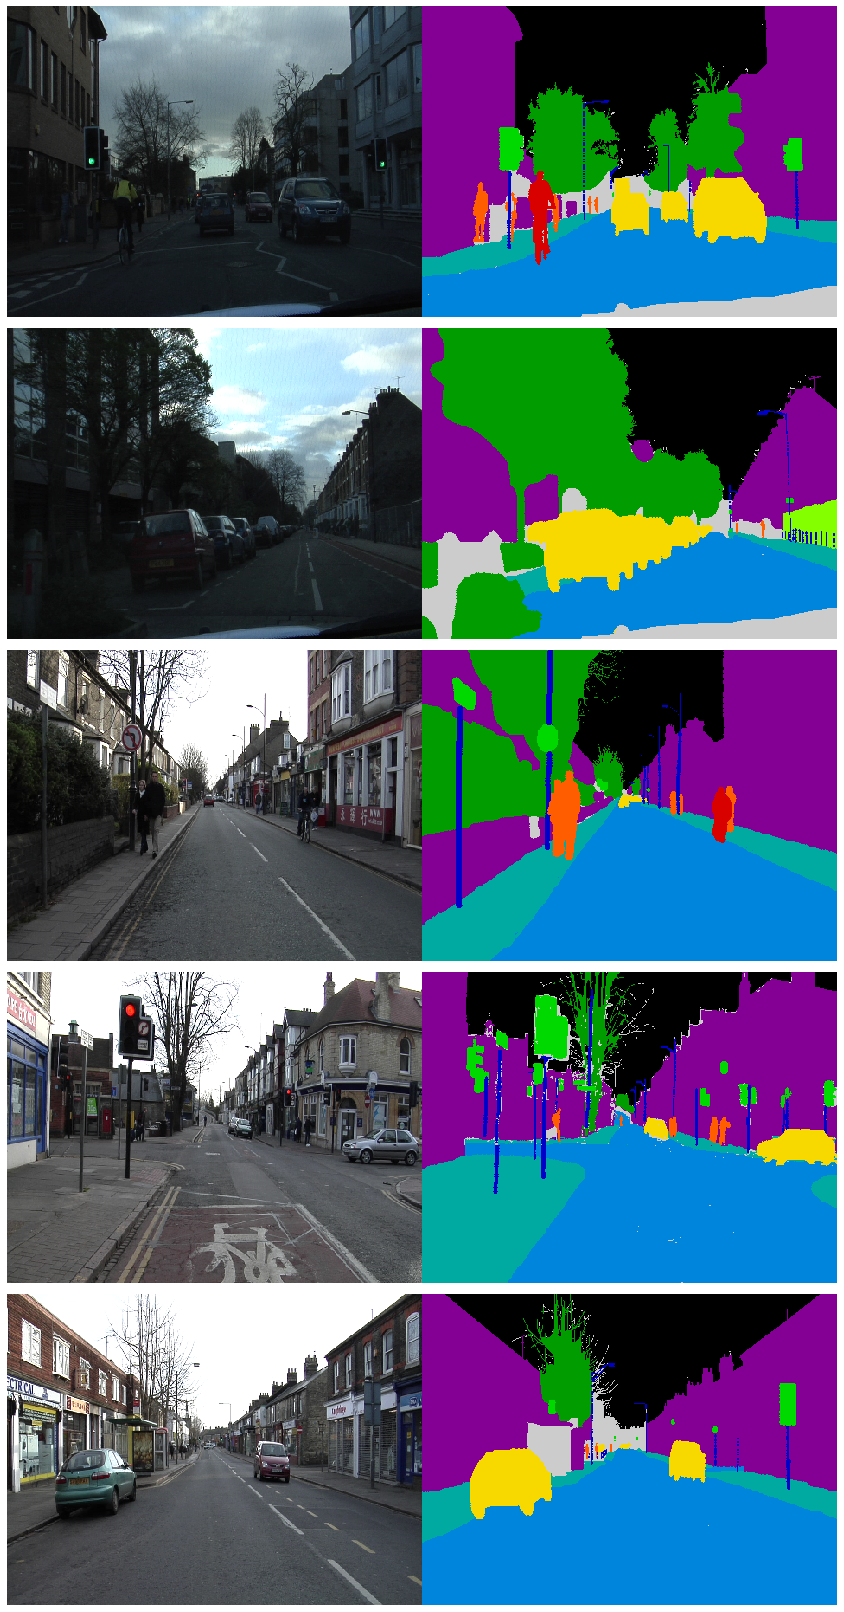

In [3]:
n = 5
f, axs = plt.subplots(n,2,figsize=(12,4.5*n))
for ii, axline in enumerate(axs):
    img, labels = map(np.array, test_set[ii*50])
    axline[0].imshow(img)
    axline[0].set_axis_off()
    #axline[1].imshow(label2rgb(labels, img.astype(np.single)/255, bg_label=0))
    axline[1].imshow(labels, vmin=0, vmax=11, cmap="nipy_spectral")
    axline[1].set_axis_off()
    
f.tight_layout()                        

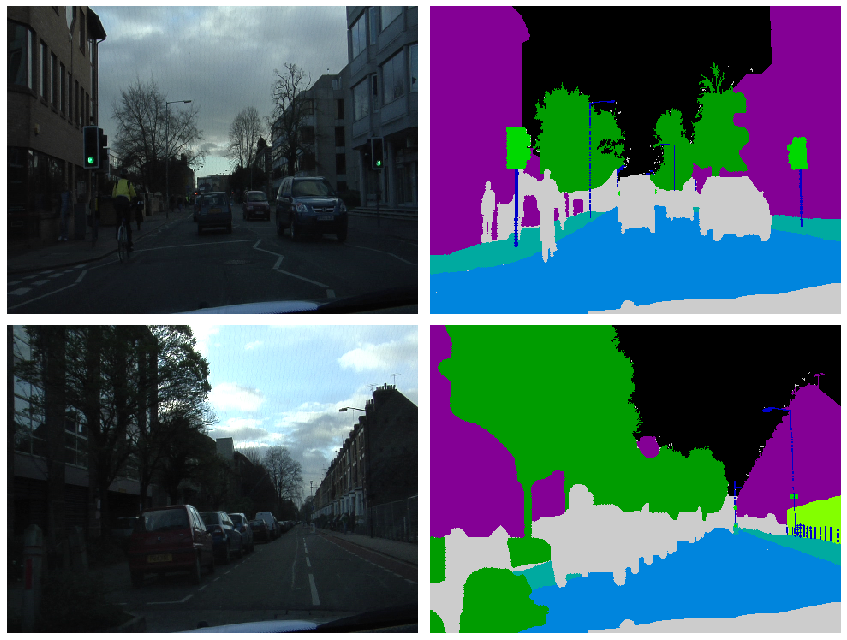

In [4]:
n = 2
f, axs = plt.subplots(n,2,figsize=(12,4.5*n))
for ii, axline in enumerate(axs):
    img, labels = test_set[ii*50]
    labels = labels.point(lambda x: x if x<8 else 11)
    img, labels = map(np.array, (img, labels))
    axline[0].imshow(img)
    axline[0].set_axis_off()
    #axline[1].imshow(label2rgb(labels, img.astype(np.single)/255, bg_label=0))
    axline[1].imshow(labels, vmin=0, vmax=11, cmap="nipy_spectral")
    axline[1].set_axis_off()
    
f.tight_layout()    

## Predictions
Below we look at the predictions for a few pictures

What we see is that the prediction confidence is almost always close to 1 in the middle of the segments, and that it only drops near the borders between segments. There is a small interpolation footprint, with a regular grid of squares with a slightly lower confidence

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_all = project_main.create_model("ENet", 12)
utils.load_checkpoint(model_all, None, "save", "ENet_allclasses_wd2")

model_8 = project_main.create_model("ENet", 9)
utils.load_checkpoint(model_8, None, "save", "ENet_8classes")

model_all, model_8 = model_all.to(device).eval(), model_8.to(device).eval()

In [6]:
def make_prediction(model, image, softmax_temp = 1.):
    tensor = TF.to_tensor(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = F.softmax(model(tensor)/softmax_temp, dim=1).detach().cpu()
        confidence, predicted_label = pred.max(dim=1)
        confidence.squeeze_(0)
        predicted_label.squeeze_(0)
    return confidence.numpy(), predicted_label.numpy()

In [7]:
def show_prediction(img_list, model, pred_map=None):
    n = len(img_list)
    f, axs = plt.subplots(n,4,figsize=(12,2.25*n))
    for ii,(axline,(img, labels)) in enumerate(zip(axs,img_list)):

        confidence, pred = make_prediction(model,img)
        if pred_map is not None:
            pred = pred_map(pred)
            
        # Image
        axline[0].imshow(img)
        
        # Ground truth
        axline[1].imshow(labels, vmin=0, vmax=11, cmap="nipy_spectral")

        # Prediction
        axline[2].imshow(pred, vmin=0, vmax=11, cmap="nipy_spectral")
        
        # Confidence
        axline[3].imshow(confidence, vmin=0.5, vmax=1., cmap="magma")
        
        for ax in axline:
            ax.set_axis_off()
    f.tight_layout()

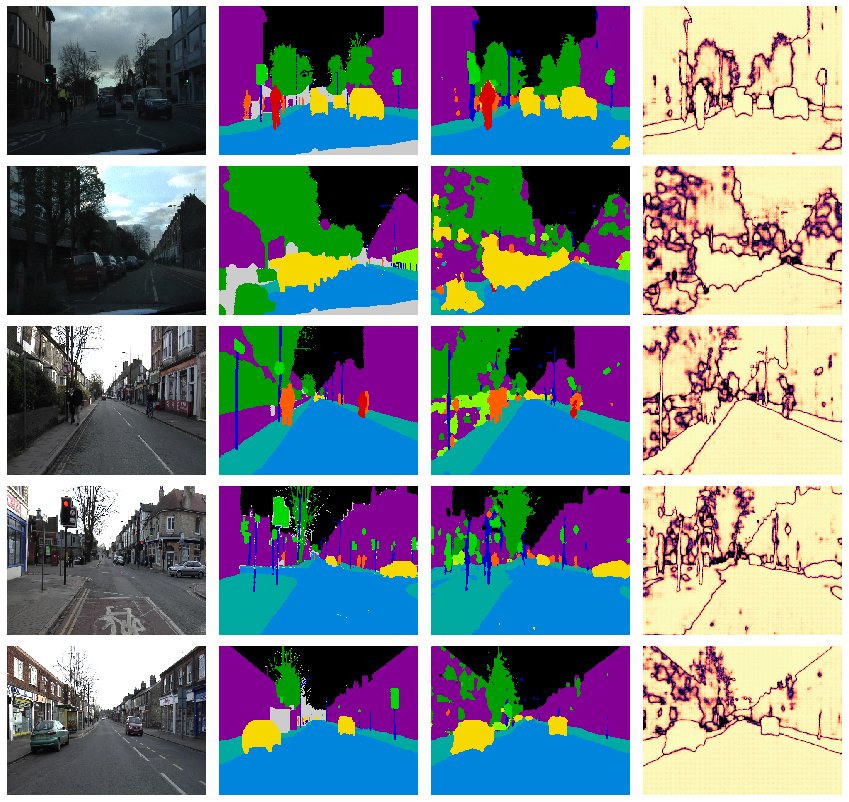

In [8]:
n=5
show_prediction([test_set[ii*50] for ii in range(n)], model_all)

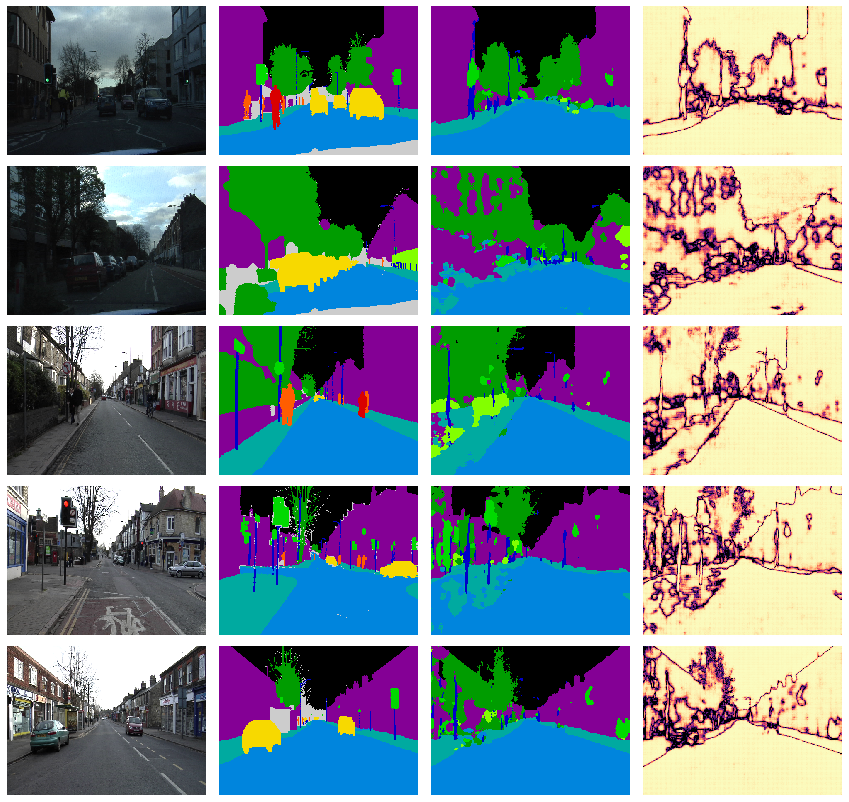

In [9]:
n=5
show_prediction([test_set[ii*50] for ii in range(n)], model_8, np.vectorize(lambda i:i if i<8 else 11))

## Histogram of confidence
An extension of the conficence matrix is built: for pair of predicted label and ground truth label, an histogram of the prediction confidence is done (rather than a mere count).

In [10]:
bin_edges = np.linspace(0,1,100)
nclass_pred = 9
nclass_gt = 12
# There are less predicted labels than ground truth labels since some classes were removed

In [11]:
bin_edges

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [12]:
test_set_tensor = CamVid(data_path,
                 mode='test',
                 transform=lambda img: TF.to_tensor(resize_fcn(img)),
                 label_transform=lambda img: np.array(resize_fcn(img),dtype=int),
                 preload=False);
test_loader = torch.utils.data.DataLoader(test_set_tensor, batch_size=10,drop_last=False,shuffle=False)

def make_predictions(model, tensor, softmax_temp = 1.):
    tensor = tensor.to(device)
    with torch.no_grad():
        pred = F.softmax(model(tensor)/softmax_temp, dim=1).detach().cpu()
        confidence, predicted_label = pred.max(dim=1)
    return confidence.numpy(), predicted_label.numpy()

In [13]:
def confidence_histogram_array(model, loader, n_gt, n_pred, bins, device=device, softmax_temp=1.):
    """
    model: model
    loader: dataloader that yields (image, label) tensors
    n_gt: number of ground-truth classes (in the label tensor)
    n_pred: number of predicted classes (number of channels of model output)
    bins: bin edges for histogram calculation
    device: torch.device, where the model is located
    """
    hist_array = np.zeros((n_gt,n_pred,len(bins)-1), dtype=int)
    
    for img, gt_label in loader:
        gt_label=gt_label.numpy()
        confidence, predicted_label = make_predictions(model, img.to(device), softmax_temp)
    
        for ii in range(n_pred):
            sel = (predicted_label == ii)
            conf_, gt_ = confidence[sel], gt_label[sel]
            
            for jj in range(n_gt):
                hist_array[jj,ii] += np.histogram(conf_[gt_ == jj], bins)[0]
    
    return hist_array

Aggregating counts across histogram bins gives the confusion matrix:

In [14]:
hist_array = confidence_histogram_array(model_8, test_loader, nclass_gt, nclass_pred, bin_edges)
print(hist_array.sum(axis=2))

[[ 6422697    54666    31739       40       29   358772     3032        7
         0]
 [  136220  7171155   248857    23083   293804  1336425   381204   315984
         0]
 [   29360   131182   187413     1917    31961    67329    10346    14387
         0]
 [      10     7141     6468 10073498   284463    16121      774     2186
         0]
 [       7    27528    15846   975645  2695840    11163     1125     4703
         0]
 [  128447   334859    42904    10791    14599  3898298    30646    70351
         0]
 [    7312   146495    18035      368      401    81588   149186     3227
         0]
 [    1225   141127    18011     7061    48581    63766    12044   184992
         0]
 [    2927   427619    50169   659317   183899   150578    70063    54552
         0]
 [      36   105475    33670     5317    36821    37659    12574    23680
         0]
 [       1    13792     9404     8879    20906    12515     3280     7443
         0]
 [   70643   405205    78223   400512   174354   29371

Aggregating counts across the two class dimensiosn give an hstogram of prediction confidence. The same histogram can also be done for all valid predictions, and for all bad predictions (ignoring pixels with "unlabeled" label). What is noticeable is that, while most of well classified pixels have a high confidence score, the mis-classified pixels often also have a high confidence.



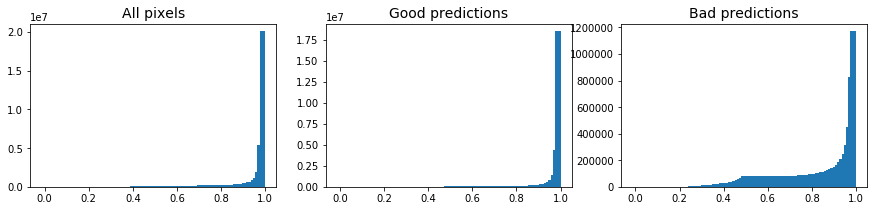

In [15]:
hist_full = hist_array.sum(axis=1).sum(axis=0)
hist_good = hist_array[np.arange(8), np.arange(8)].sum(axis=0)
hist_bad = hist_array[:11, :8].sum(axis=1).sum(axis=0)- hist_good

def plot_bar(ax, data, title, **bar_kwargs):
    width = -np.diff(bin_edges).min()
    ax.bar(bin_edges[1:], data, width=-0.025, align='edge', data=None, **bar_kwargs)
    ax.set_title(title, fontsize=14)


f, axs = plt.subplots(1,3,figsize=(15,3))
plot_bar(axs[0],hist_full,"All pixels")
plot_bar(axs[1],hist_good,"Good predictions")
plot_bar(axs[2],hist_bad,"Bad predictions")

We can also plot the histogram of confidence for pixels belonging to the three classes that were removed from the labels.

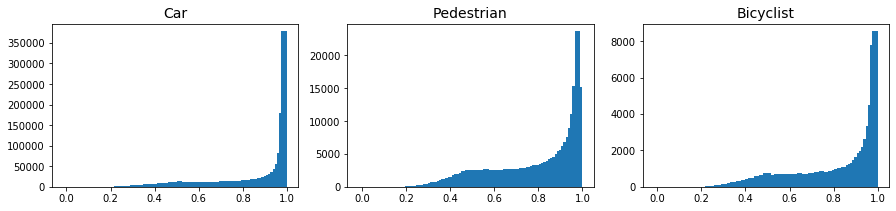

In [16]:
hist_car, hist_pedestrian, hist_bicyclist = hist_array[8:11].sum(axis=1)

f, axs = plt.subplots(1,3,figsize=(15,3))
plot_bar(axs[0],hist_car,"Car")
plot_bar(axs[1],hist_pedestrian,"Pedestrian")
plot_bar(axs[2],hist_bicyclist,"Bicyclist")

**We notice that for the mis-classified pixels, and especially the three categories removed from the data, a large proportion of predictions is done with a high confidence (maximum softmax probability > 90%)**

### Varying softmax temperature
A first option is to adjust the temperature $T$ of the softmax. The i-th component $s_i$ of the softmax of vector $x$ is:

$s_i = \frac{\exp \left({\dfrac{x_i}{T}}\right)}{\sum_i \exp \left({\dfrac{x_i}{T}}\right)}$

We compute the histogram array for several temperatures. High temperatures tend to decreae the confidence (with an equiprobable probability for each class with an infinite temperature), while low temperatures tend to reinforce the confidence.

We can also draw an approximate ROC AUC curve.

Softmax temperature 1.3, ROC AUC is 0.8090
Softmax temperature 1.5, ROC AUC is 0.8102
Softmax temperature 1.8, ROC AUC is 0.8103


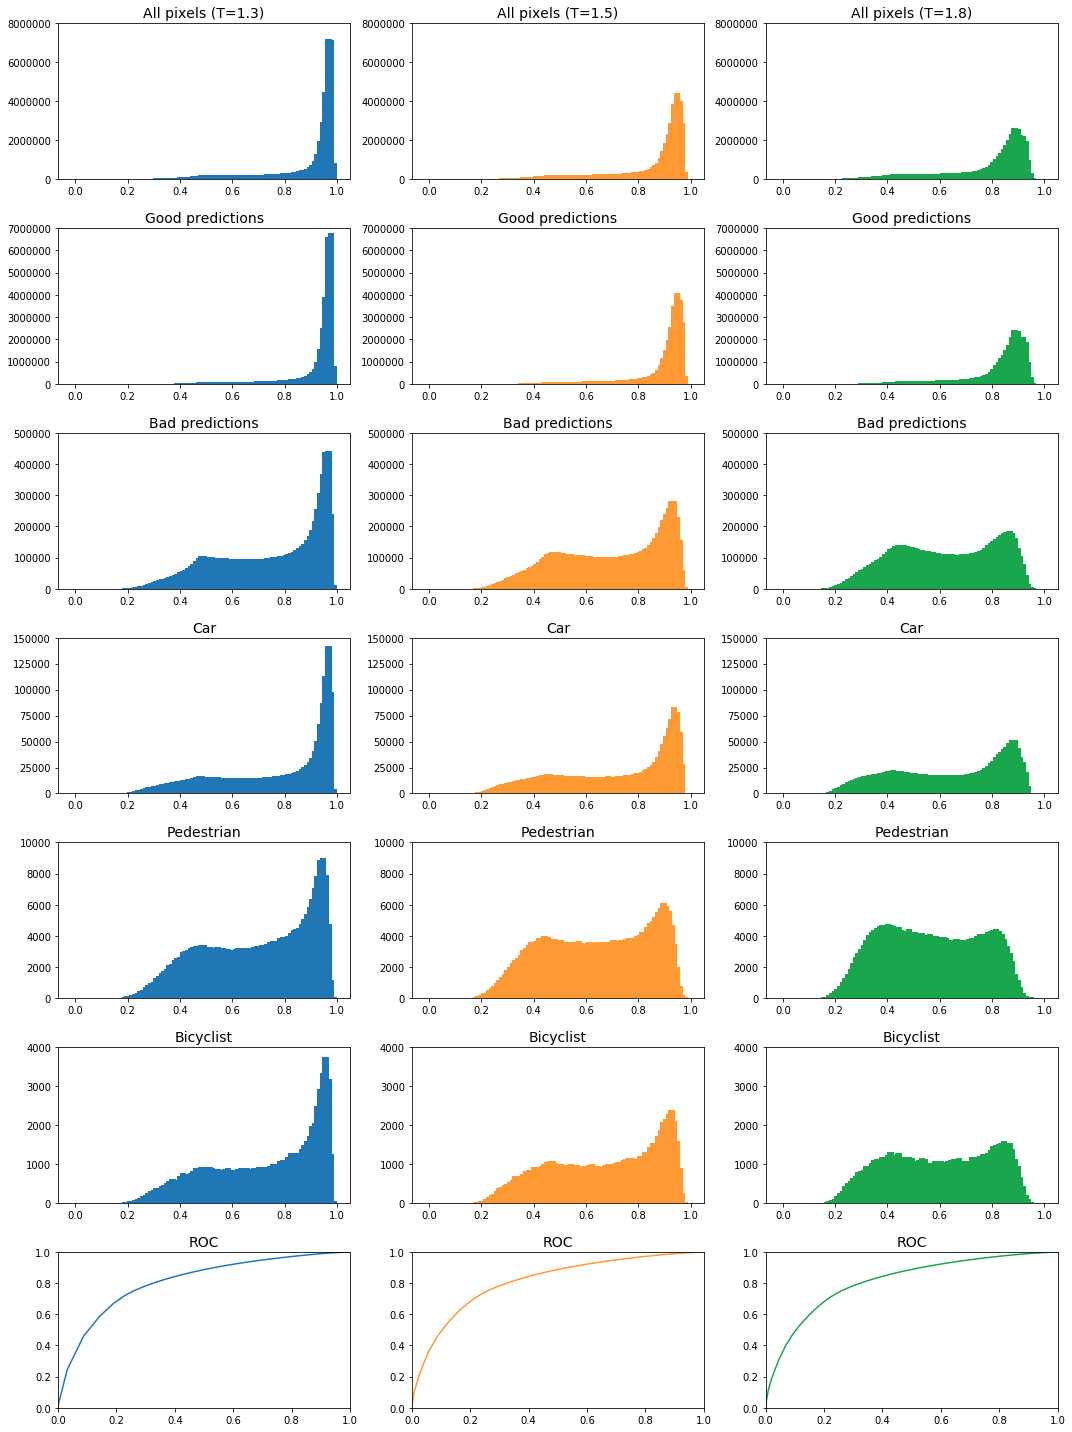

In [50]:
f, axs = plt.subplots(7,3,figsize=(15,20))
temperatures = [1.3,1.5,1.8]
colors = [[.12,.47, .71], [1,.6, .2], [.1,.65,.3]]
limits = [8e6, 7e6, 5e5, 1.5e5, 1e4, 4e3]
for col, (T, color) in enumerate(zip(temperatures, colors)):
    hist_array = confidence_histogram_array(model_8, test_loader, nclass_gt, nclass_pred, bin_edges, softmax_temp=T)
    hist_full = hist_array.sum(axis=1).sum(axis=0)
    hist_good = hist_array[np.arange(8), np.arange(8)].sum(axis=0)
    hist_bad = hist_array[:11, :8].sum(axis=1).sum(axis=0)- hist_good
    hist_car, hist_pedestrian, hist_bicyclist = hist_array[8:11].sum(axis=1)
    plot_bar(axs[0][col],hist_full,"All pixels (T={:.1f})".format(T), color=color)
    plot_bar(axs[1][col],hist_good,"Good predictions", color=color)
    plot_bar(axs[2][col],hist_bad,"Bad predictions", color=color)
    plot_bar(axs[3][col],hist_car,"Car", color=color)
    plot_bar(axs[4][col],hist_pedestrian,"Pedestrian", color=color)
    plot_bar(axs[5][col],hist_bicyclist,"Bicyclist", color=color)
    for ii in range(6):
            axs[ii][col].set_ylim(0,limits[ii])

    false_pos_rate = np.hstack((1., 1-hist_bad.cumsum()/hist_bad.sum(), 0.))[::-1]
    true_pos_rate = np.hstack((1., 1-hist_good.cumsum()/hist_good.sum(), 0.))[::-1]
    axs[6][col].plot(false_pos_rate, true_pos_rate, color=color)
    axs[6][col].set_xlim(0,1)
    axs[6][col].set_ylim(0,1)
    axs[6][col].set_title("ROC", fontsize=14)
    roc_auc = cumtrapz(y=true_pos_rate, x=false_pos_rate)[-1]
    print("Softmax temperature {:.1f}, ROC AUC is {:.4f}".format(T, roc_auc))
    
f.tight_layout(h_pad=1.5)

Softmax temperature 2.0, ROC AUC is 0.8101
Softmax temperature 2.5, ROC AUC is 0.8093
Softmax temperature 3.0, ROC AUC is 0.8084


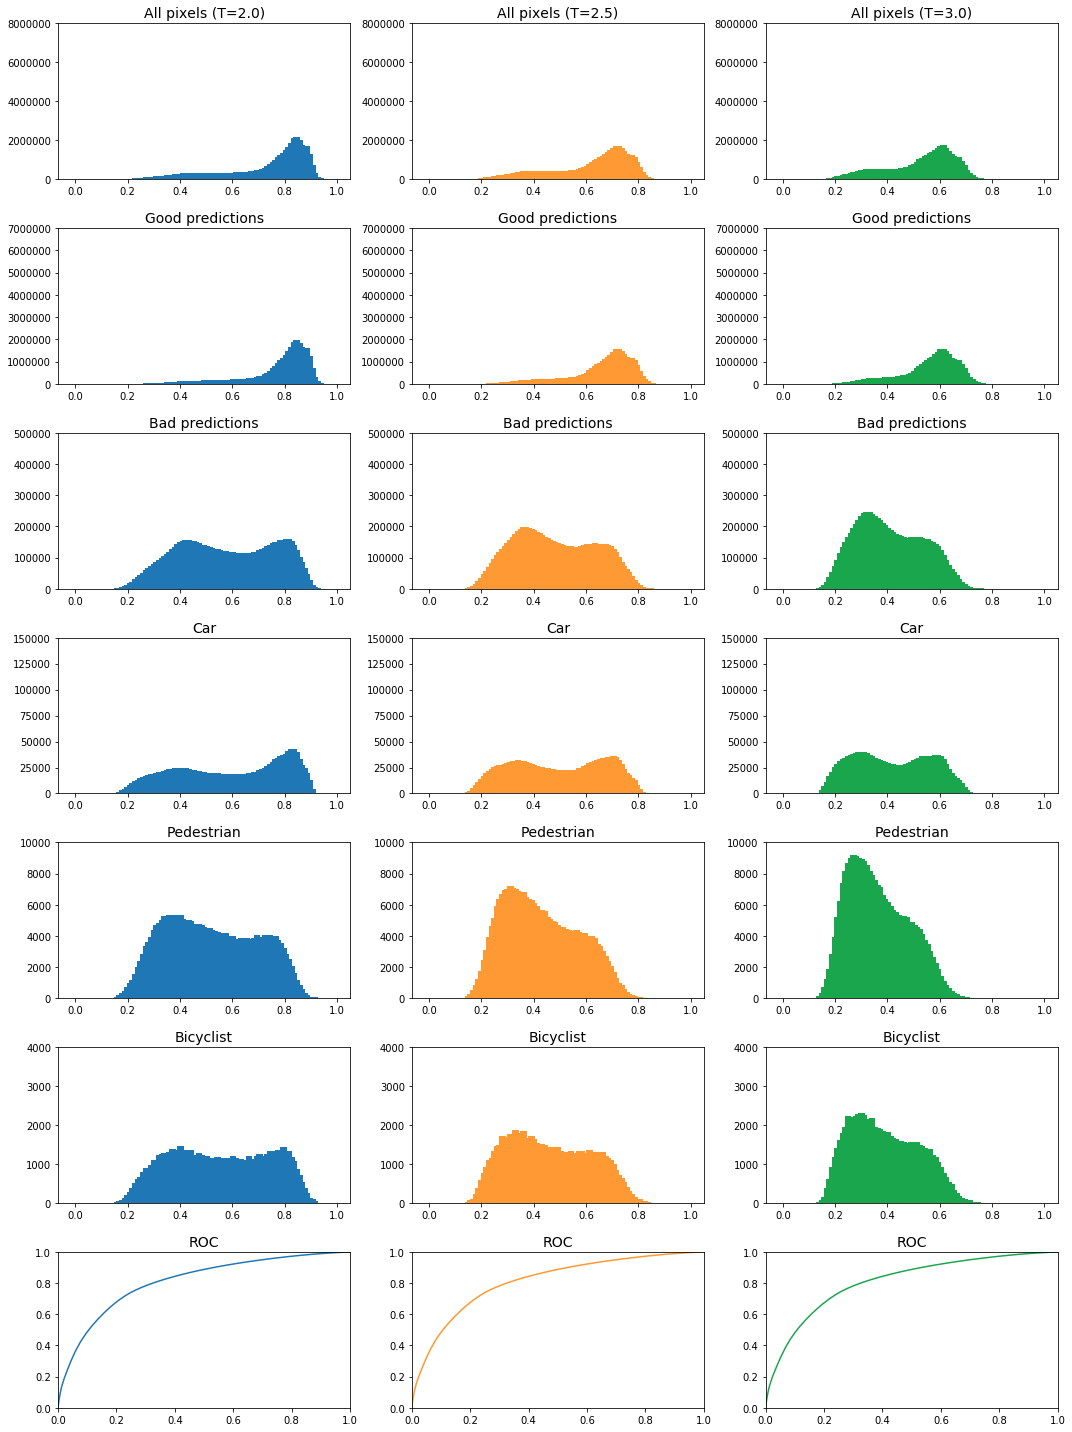

In [51]:
f, axs = plt.subplots(7,3,figsize=(15,20))
temperatures = [2.0,2.5,3.0]
colors = [[.12,.47, .71], [1,.6, .2], [.1,.65,.3]]
limits = [8e6, 7e6, 5e5, 1.5e5, 1e4, 4e3]
for col, (T, color) in enumerate(zip(temperatures, colors)):
    hist_array = confidence_histogram_array(model_8, test_loader, nclass_gt, nclass_pred, bin_edges, softmax_temp=T)
    hist_full = hist_array.sum(axis=1).sum(axis=0)
    hist_good = hist_array[np.arange(8), np.arange(8)].sum(axis=0)
    hist_bad = hist_array[:11, :8].sum(axis=1).sum(axis=0)- hist_good
    hist_car, hist_pedestrian, hist_bicyclist = hist_array[8:11].sum(axis=1)
    plot_bar(axs[0][col],hist_full,"All pixels (T={:.1f})".format(T), color=color)
    plot_bar(axs[1][col],hist_good,"Good predictions", color=color)
    plot_bar(axs[2][col],hist_bad,"Bad predictions", color=color)
    plot_bar(axs[3][col],hist_car,"Car", color=color)
    plot_bar(axs[4][col],hist_pedestrian,"Pedestrian", color=color)
    plot_bar(axs[5][col],hist_bicyclist,"Bicyclist", color=color)
    for ii in range(6):
            axs[ii][col].set_ylim(0,limits[ii])

    false_pos_rate = np.hstack((1., 1-hist_bad.cumsum()/hist_bad.sum(), 0.))[::-1]
    true_pos_rate = np.hstack((1., 1-hist_good.cumsum()/hist_good.sum(), 0.))[::-1]
    axs[6][col].plot(false_pos_rate, true_pos_rate, color=color)
    axs[6][col].set_xlim(0,1)
    axs[6][col].set_ylim(0,1)
    axs[6][col].set_title("ROC", fontsize=14)
    roc_auc = cumtrapz(y=true_pos_rate, x=false_pos_rate)[-1]
    print("Softmax temperature {:.1f}, ROC AUC is {:.4f}".format(T, roc_auc))
    
f.tight_layout(h_pad=1.5)

The use of a higher temperature yields a maximum softmax value that is perhaps more representative of the actual confidence in the prediction. It does not change the usefulness of the maximum softmax value in predicting whether a pixel is well classified or not. **If we attempt to predict the correctness of predictions with a threshold on the MSV, the ROC curve is barely affected by the softmax temparature (and the ROC AUC does not change).**

## MC Dropout
MC Dropout is done with models with a 15% dropout during training but alos for inference. Inference is repeated several times for the same image and we can look at the distribution of the predictions.
Here, we use two methods:
- compute the average of the (soft) predictions and pick the class with the highest average. The variance of the predictions is also computed, and the confidence is taken as the average minus $\kappa$ standard deviations.
- another option is a vote: the prediction is the mode of the hard predictions (i.E. the class that is most often predicted acoss all inferences) and the confidence is the number of times this class was predicted over the number of inferences.

In [19]:
DROPOUT_RATE = 0.15

model_MCdrop = project_main.create_model("ENet", 9)
utils.load_checkpoint(model_MCdrop, None, "save", "ENet_dropout")
utils.add_dropout(model_MCdrop, DROPOUT_RATE)
model_MCdrop = model_MCdrop.cuda()

In [20]:
def show_prediction_tensor(images, predictions, labels, confidences):
    def to_np(tensor):
        return tensor.detach().cpu().numpy()
    n = images.size(0)
    f, axs = plt.subplots(n,4,figsize=(12,2.25*n))
    for ii,(axline,img, pred, gt, conf) in enumerate(zip(axs,images, predictions, labels, confidences)):

        # Image
        axline[0].imshow(np.moveaxis(to_np(img),0,2))
        
        # Ground truth
        axline[1].imshow(gt, vmin=0, vmax=11, cmap="nipy_spectral")

        # Prediction
        disp_pred = np.vectorize(lambda i:i if i<8 else 11)(to_np(pred))
        axline[2].imshow(disp_pred, vmin=0, vmax=11, cmap="nipy_spectral")
        
        # Confidence
        axline[3].imshow(to_np(conf), vmin=0.0, vmax=1., cmap="viridis")
        
        for ax in axline:
            ax.set_axis_off()
    f.tight_layout()

In [21]:
img, labels = zip(*[test_set_tensor[ii*50] for ii in range(n)])
img = torch.stack(img).cuda()
labels = np.stack(labels)

In [22]:
torch.cuda.empty_cache()

In [23]:
pred_MC = []
n_MC = 24
with torch.no_grad():
    pred_noMC = model_8(img).cpu()
    pred_MC = torch.zeros((n_MC, *pred_noMC.shape), dtype=torch.float32)
    for ii in range(n_MC):
        pred_MC[ii] = model_MCdrop(img).softmax(dim=1).detach().cpu()
    mean_MC = pred_MC.mean(dim=0)
    var_MC = pred_MC.var(dim=0)
    
    count_MC = torch.zeros(mean_MC.shape, dtype=torch.long)
    label_MC = torch.max(pred_MC,dim=2)[1]
    for label in range(count_MC.size(1)):
        count_MC[:,label,:,:] = label_MC.eq(label).sum(dim=0)

Try to average the MSV across several runs

In [24]:
conf, prediction = mean_MC.max(dim=1)
variance = var_MC.gather(1, prediction.unsqueeze(1)).squeeze(1)

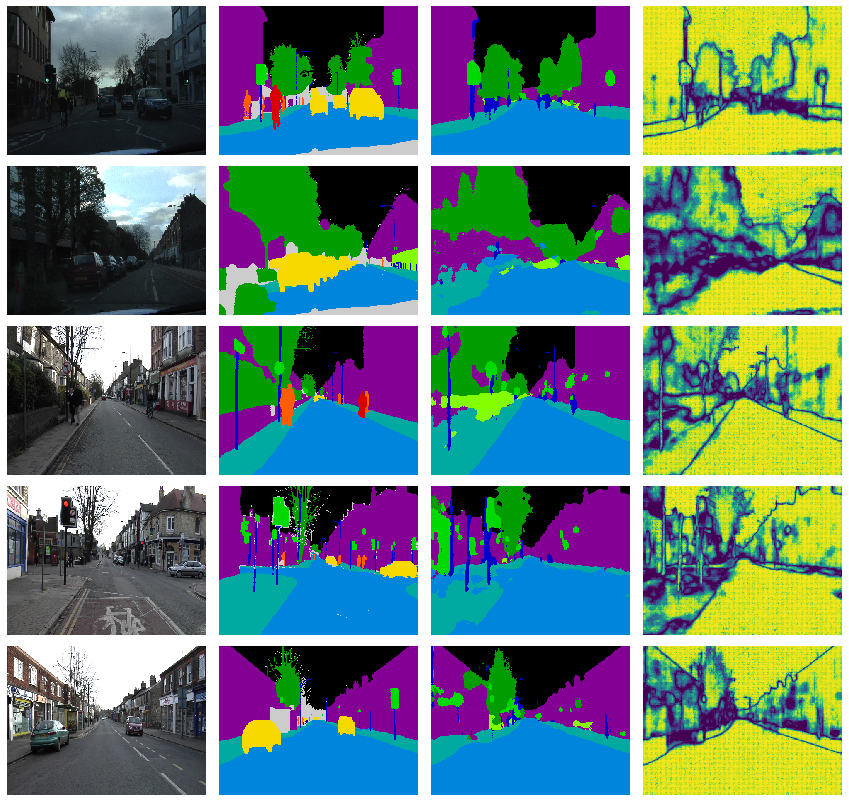

In [25]:
optimism = -1.5 # could change 
show_prediction_tensor(img, prediction, labels, torch.clamp(conf + optimism*torch.sqrt(variance), 0.,1.))

In [26]:
conf, prediction = count_MC.max(dim=1)
conf = conf.float()/n_MC

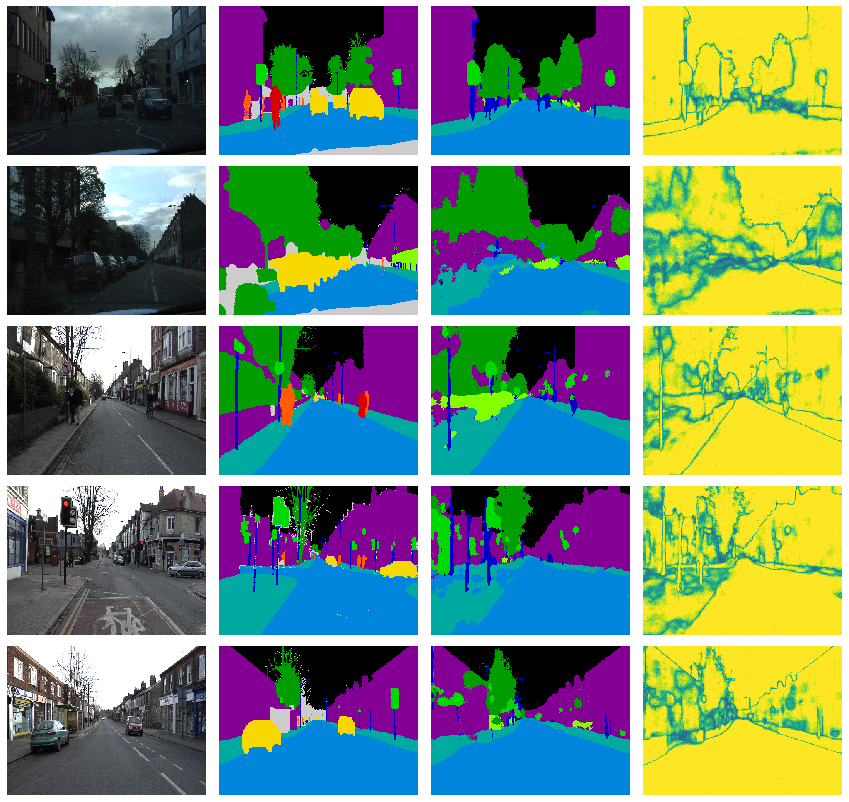

In [27]:
show_prediction_tensor(img, prediction, labels, conf)

**Visually, both methods give very similar predictions. Both are tried with the MC dropout and the first one with aggregate multiple models**

First, MC dropout with the average softmax value:

In [28]:
hist_array, iou, miou = evaluate_model_MCdrop(model_MCdrop, test_loader, nclass_gt, nclass_pred, bin_edges,
                                             softmax_temperature = 1.5, kappa=-1.0, method="mean")

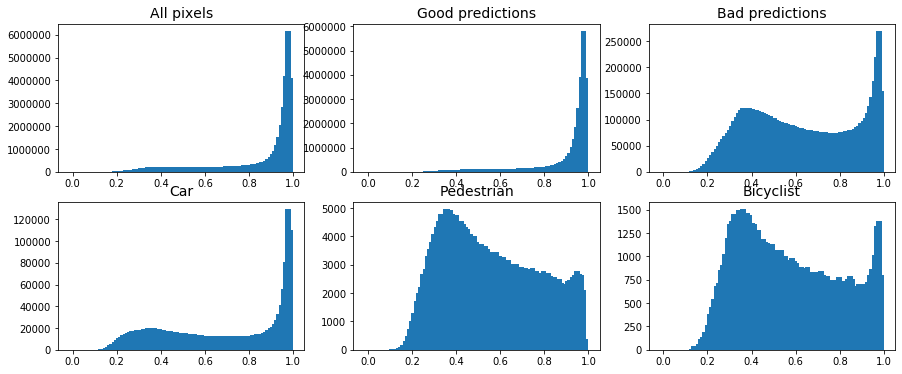

In [29]:
hist_full = hist_array.sum(axis=1).sum(axis=0)
hist_good = hist_array[np.arange(8), np.arange(8)].sum(axis=0)
hist_bad = hist_array[:11, :8].sum(axis=1).sum(axis=0)- hist_good

hist_car, hist_pedestrian, hist_bicyclist = hist_array[8:11].sum(axis=1)

f, axs = plt.subplots(2,3,figsize=(15,6))
plot_bar(axs[0][0],hist_full,"All pixels")
plot_bar(axs[0][1],hist_good,"Good predictions")
plot_bar(axs[0][2],hist_bad,"Bad predictions")

plot_bar(axs[1][0],hist_car,"Car")
plot_bar(axs[1][1],hist_pedestrian,"Pedestrian")
plot_bar(axs[1][2],hist_bicyclist,"Bicyclist")

ROC AUC is 0.8179


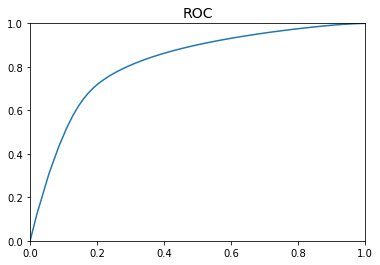

In [30]:
false_pos_rate = np.hstack((1., 1-hist_bad.cumsum()/hist_bad.sum(), 0.))[::-1]
true_pos_rate = np.hstack((1., 1-hist_good.cumsum()/hist_good.sum(), 0.))[::-1]
plt.plot(false_pos_rate, true_pos_rate)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("ROC", fontsize=14)
roc_auc = cumtrapz(y=true_pos_rate, x=false_pos_rate)[-1]
print("ROC AUC is {:.4f}".format(roc_auc))


Another attempt is done with the count of predictions:

In [31]:
hist_array, iou, miou = evaluate_model_MCdrop(model_MCdrop, test_loader, nclass_gt, nclass_pred, bin_edges,
                                             softmax_temperature = 1.5, kappa=-1.0, method="count")

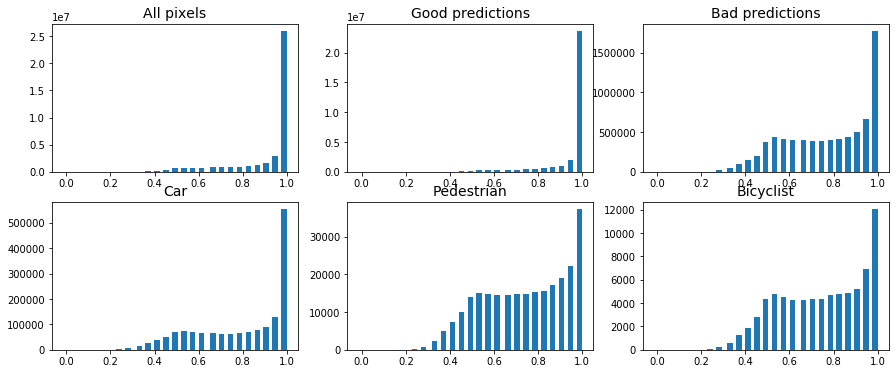

In [32]:
hist_full = hist_array.sum(axis=1).sum(axis=0)
hist_good = hist_array[np.arange(8), np.arange(8)].sum(axis=0)
hist_bad = hist_array[:11, :8].sum(axis=1).sum(axis=0)- hist_good

hist_car, hist_pedestrian, hist_bicyclist = hist_array[8:11].sum(axis=1)

f, axs = plt.subplots(2,3,figsize=(15,6))
plot_bar(axs[0][0],hist_full,"All pixels")
plot_bar(axs[0][1],hist_good,"Good predictions")
plot_bar(axs[0][2],hist_bad,"Bad predictions")

plot_bar(axs[1][0],hist_car,"Car")
plot_bar(axs[1][1],hist_pedestrian,"Pedestrian")
plot_bar(axs[1][2],hist_bicyclist,"Bicyclist")

ROC AUC is 0.7922


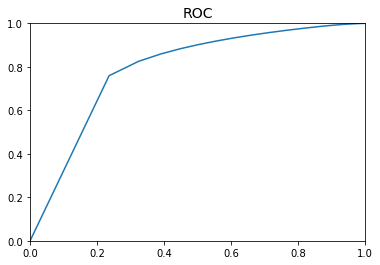

In [33]:
false_pos_rate = np.hstack((1., 1-hist_bad.cumsum()/hist_bad.sum(), 0.))[::-1]
true_pos_rate = np.hstack((1., 1-hist_good.cumsum()/hist_good.sum(), 0.))[::-1]
plt.plot(false_pos_rate, true_pos_rate)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("ROC", fontsize=14)
roc_auc = cumtrapz(y=true_pos_rate, x=false_pos_rate)[-1]
print("ROC AUC is {:.4f}".format(roc_auc))


## Aggregation

Instead of using the stochastic nature of MC dropout, aggregation relies on several networks trained from different initial conditions.

In [34]:
model_names = ["ENet_8classes"+c for c in ["","1","2","3","4"]]
models = []
for ii, name in enumerate(model_names):
    models.append(project_main.create_model("ENet", 9))
    utils.load_checkpoint(models[ii], None, "save", name)
    models[ii] = models[ii].cuda()

In [35]:
import importlib, aggregate
importlib.reload(aggregate)
evaluate_model_aggregate = aggregate.evaluate_model_aggregate
evaluate_model_MCdrop = aggregate.evaluate_model_MCdrop

In [37]:
hist_array, iou, miou = evaluate_model_aggregate(models, test_loader, nclass_gt, nclass_pred, bin_edges,
                                                softmax_temperature = 1.5, kappa=-1.0)

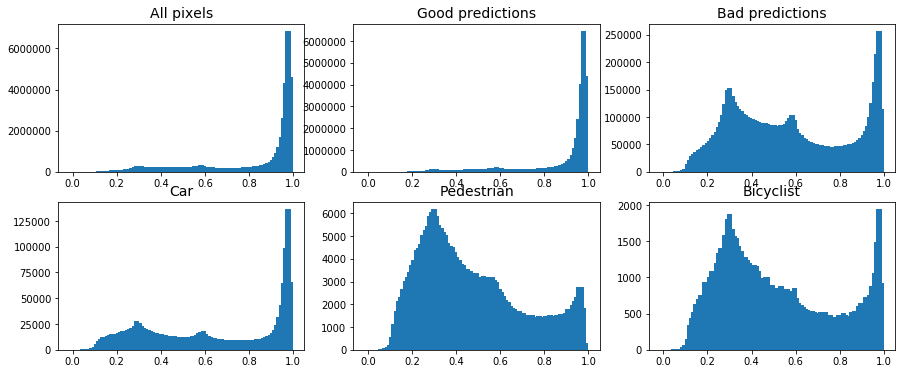

In [38]:
hist_full = hist_array.sum(axis=1).sum(axis=0)
hist_good = hist_array[np.arange(8), np.arange(8)].sum(axis=0)
hist_bad = hist_array[:11, :8].sum(axis=1).sum(axis=0)- hist_good

hist_car, hist_pedestrian, hist_bicyclist = hist_array[8:11].sum(axis=1)

f, axs = plt.subplots(2,3,figsize=(15,6))
plot_bar(axs[0][0],hist_full,"All pixels")
plot_bar(axs[0][1],hist_good,"Good predictions")
plot_bar(axs[0][2],hist_bad,"Bad predictions")

plot_bar(axs[1][0],hist_car,"Car")
plot_bar(axs[1][1],hist_pedestrian,"Pedestrian")
plot_bar(axs[1][2],hist_bicyclist,"Bicyclist")

ROC AUC is 0.8246


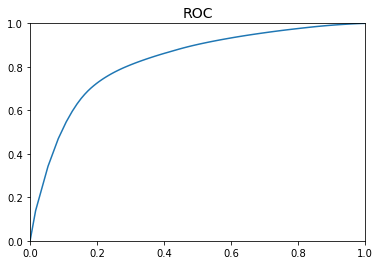

In [39]:
false_pos_rate = np.hstack((1., 1-hist_bad.cumsum()/hist_bad.sum(), 0.))[::-1]
true_pos_rate = np.hstack((1., 1-hist_good.cumsum()/hist_good.sum(), 0.))[::-1]
plt.plot(false_pos_rate, true_pos_rate)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("ROC", fontsize=14)
roc_auc = cumtrapz(y=true_pos_rate, x=false_pos_rate)[-1]
print("ROC AUC is {:.4f}".format(roc_auc))


## BiSeNet Model

In [40]:
DROPOUT_RATE = 0.15
args = CustomArgs(model_type="BiSeNet", dropout=0.15)

model_BiSeNEt_MC = project_main.create_model(args, 9)
utils.load_checkpoint(model_BiSeNEt_MC, None, "save", "BiSeNet_dropout")
model_BiSeNEt_MC = model_BiSeNEt_MC.cuda()

In [41]:
hist_array, iou, miou = evaluate_model_MCdrop(model_BiSeNEt_MC, test_loader, nclass_gt, nclass_pred, bin_edges,
                                             softmax_temperature = 1.5, kappa=-1.0, method="mean")

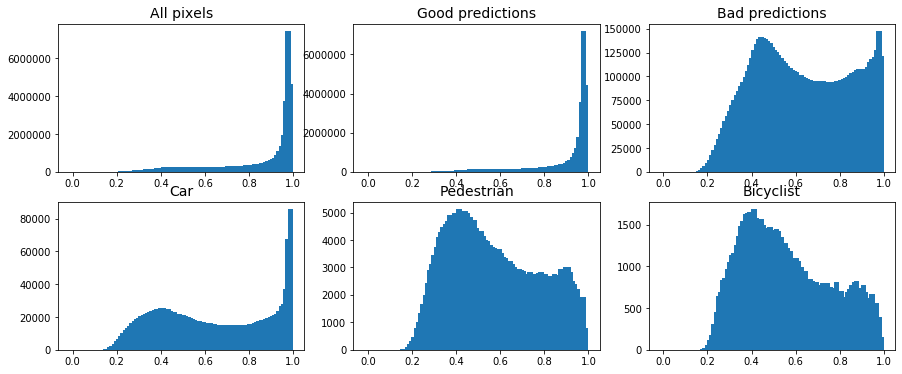

In [42]:
hist_full = hist_array.sum(axis=1).sum(axis=0)
hist_good = hist_array[np.arange(8), np.arange(8)].sum(axis=0)
hist_bad = hist_array[:11, :8].sum(axis=1).sum(axis=0)- hist_good

hist_car, hist_pedestrian, hist_bicyclist = hist_array[8:11].sum(axis=1)

f, axs = plt.subplots(2,3,figsize=(15,6))
plot_bar(axs[0][0],hist_full,"All pixels")
plot_bar(axs[0][1],hist_good,"Good predictions")
plot_bar(axs[0][2],hist_bad,"Bad predictions")

plot_bar(axs[1][0],hist_car,"Car")
plot_bar(axs[1][1],hist_pedestrian,"Pedestrian")
plot_bar(axs[1][2],hist_bicyclist,"Bicyclist")

ROC AUC is 0.8384


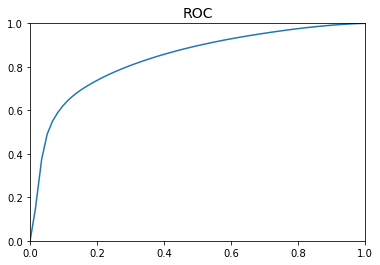

In [43]:
false_pos_rate = np.hstack((1., 1-hist_bad.cumsum()/hist_bad.sum(), 0.))[::-1]
true_pos_rate = np.hstack((1., 1-hist_good.cumsum()/hist_good.sum(), 0.))[::-1]
plt.plot(false_pos_rate, true_pos_rate)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("ROC", fontsize=14)
roc_auc = cumtrapz(y=true_pos_rate, x=false_pos_rate)[-1]
print("ROC AUC is {:.4f}".format(roc_auc))


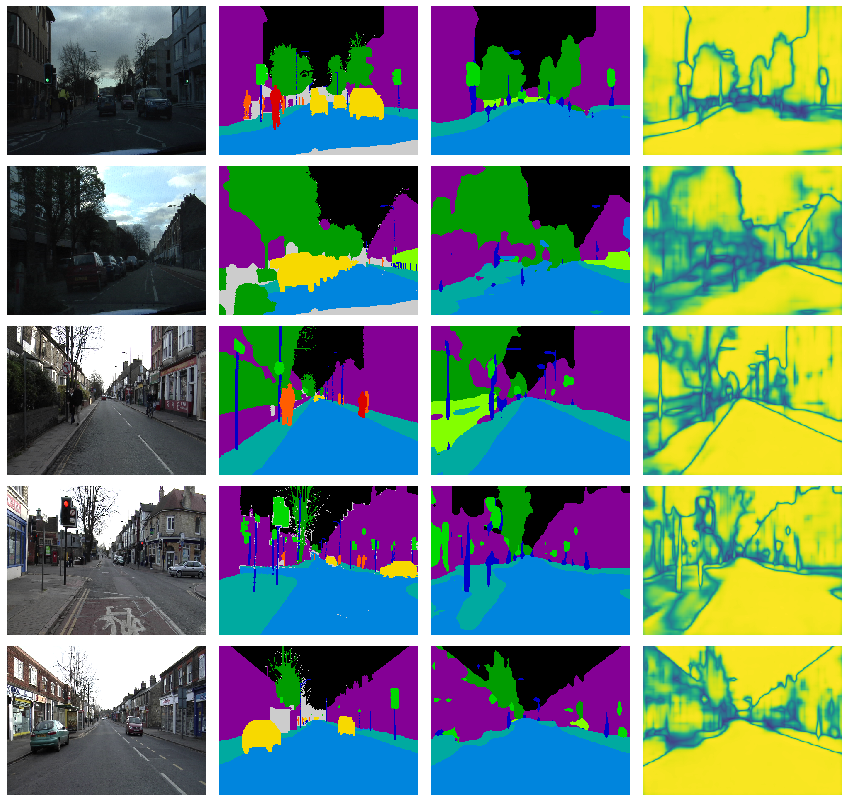

In [49]:
img, labels = zip(*[test_set_tensor[ii*50] for ii in range(n)])
img = torch.stack(img).cuda()
labels = np.stack(labels)

prediction, mean_confidence, variance = MC_prediction(model_BiSeNEt_MC, img, n_MC=24, softmax_temperature=1.5)
confidence = torch.clamp(mean_confidence - variance,0.,1.) 
show_prediction_tensor(img, prediction, labels, confidence)